<h1 style="text-align: center;">Sentiment Analysis of Social Media Posts in Roman Urdu
</h1>
<h3 style="text-align: center;">Special Focus: Prediction of negative Sentiment</h3>
<h5 style="text-align: center;">
    <i> Prepared by: Sebastian Rauschert, PhD</i>
<h5>

# Summarised Overview   
    
- Data inspection and cleaning
- NLP processing such as tokenisation, removal of stop words and creation of n-grams
- Machine Learning Models  
    -  Multinomial Logistic Regression  
    - Naive Bayes Classifier   
- Conclusions
- Closing Remarks and Outlook
    
    
NOTE: Further information on how I gathered information on the Urdu language and Natural Language Processing in general, can be found in the README file in this project folder.

In [1]:
# My own module, to not clutter the notebook with functions
import urdu_sentiment.plotting as customPlt
from  urdu_sentiment.tokenise import createToken, tokeniseAll

# Importing all libraries for the analysis
import nltk 
import itertools
import pandas as pd
import numpy as np
from numpy import loadtxt
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, 
                             accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score, 
                             roc_auc_score, 
                             roc_curve, 
                             precision_recall_curve, 
                             plot_roc_curve, 
                             classification_report, 
                             auc, 
                             cohen_kappa_score)
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MaxAbsScaler

plt.rcParams['figure.figsize'] = [10, 5]
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/srauschert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Descriptives and Cleaning
Here I:  

1. Inspect the data. 
2. Clean the data (class assignment, missing values, outlier removal)

### Import data

In [2]:
# Read the Urdu data set
urdu = pd.read_csv('../data/Roman_Urdu_DataSet.csv', header=None, names=['post', 'sentiment', 'unknown'])

# Read the stopwords
stopWords = pd.read_csv("../data/stopwords.txt", header=None)[0].tolist()

# Read the list of common names in Urdu
urduNames = pd.read_csv("../data/100-common-names.txt", header=None)[0].tolist()

# Check data dimensions
print('The Urdu data set has', urdu.shape[0], 'rows and', urdu.shape[1], 'colums')

The Urdu data set has 20229 rows and 3 colums


In [3]:
# Inspecting the head of the data to see if it was loaded
urdu.head(10)

,post,sentiment,unknown
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,NaN
1,sahi bt h,Positive,NaN
2,"Kya bt hai,",Positive,NaN
3,Wah je wah,Positive,NaN
4,Are wha kaya bat hai,Positive,NaN
5,Wah kya baat likhi,Positive,NaN
6,Wha Itni sari khubiya,Positive,NaN
7,Itni khubiya,Positive,NaN
8,Ya allah rehm farma hm sab pe or zalimo ko hid...,Positive,NaN
9,Please Everyone AllAh S.w.T ka naam hAmesha Ba...,Positive,NaN


NOTE: The comments are a mix of english and Roman Urdu

### Inspect the classes

In [4]:
# Inspect the categories to see if there are any issues
# I do this by creating a new pandas data frame, as we can later on plot the results easy with this
categories            = pd.DataFrame(urdu['sentiment'].value_counts())
categories.index.name = 'Categories'
categories            = categories.reset_index()
categories.columns    = ['Categories', 'Counts']
categories

,Categories,Counts
0,Neutral,8929
1,Positive,6013
2,Negative,5286
3,Neative,1


NOTE: We can see that there is a type error in one instance of the 'Negative' class. As it is obvious that this is meant to be a 'Negative' instance, I am just going to recode it to 'Negative'. 

In [5]:
urdu[urdu['sentiment'] == 'Neative'] = 'Negative'
categories            = pd.DataFrame(urdu['sentiment'].value_counts())
categories.index.name = 'Categories'
categories            = categories.reset_index()
categories.columns    = ['Categories', 'Counts']
categories

,Categories,Counts
0,Neutral,8929
1,Positive,6013
2,Negative,5287


### Missing values and column 3

Let's check the number of missing values per variable, and in doing that, check what the third column is all about

In [6]:
urdu.isnull().sum()

post             1
sentiment        0
unknown      20221
dtype: int64

NOTE: Column 3 appears as non-useful. It is also not described anywhere, if there 
is any meaning to it. Hence we will drop it for the further analysis.

In [7]:
# Permanently remove column 3 
urdu.drop(columns='unknown', inplace=True)
urdu.head()

,post,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


Further, as per 'missingness' check above, there is one missing value in the 'Comments', so let's inspect this

In [8]:
print(urdu[urdu["post"].isnull()])

      post sentiment
16904  NaN   Neutral


NOTE: As this is one occurance out of 20229, I decided to remove this instance. After all, we need text to perform the classification, and having one occurence of missing comments for a neutral review is not enough to indicate that there is a pattern of 'neutral' reviewers to not leave a comment.

In [9]:
urdu.drop(index=16904, inplace=True)
print(urdu[urdu["post"].isnull()])

# Reset the index
urdu.reset_index(drop=True, inplace=True)

Empty DataFrame
Columns: [post, sentiment]
Index: []


### Inspect classes randomly

In [10]:
print('Random positive comment')
print(urdu[urdu['sentiment']=='Positive'].sample(n=1)['post'].iloc[0])
print('=========================')
print('Random neutral comment')
print(urdu[urdu['sentiment']=='Neutral'].sample(n=1)['post'].iloc[0])
print('=========================')
print('Random negative comment')
print(urdu[urdu['sentiment']=='Negative'].sample(n=1)['post'].iloc[0])

Random positive comment
Hamain Allah ko Capital A se likhna chahiye.Agar UK 1 saal rehne ke baad bhi nahi hue to hamain apne spelling theek karne chahiye
Random neutral comment
        
Random negative comment
Ye arsal ka gareban kabi band Q ni hota


### Check the number of words per class
It might be useful to get an understanding of the length of sentences per class. Further, we want to make sure there are no comments with no words or ouliers with many more words than the majority of comments.

<AxesSubplot:xlabel='Sentiment', ylabel='WordCount'>

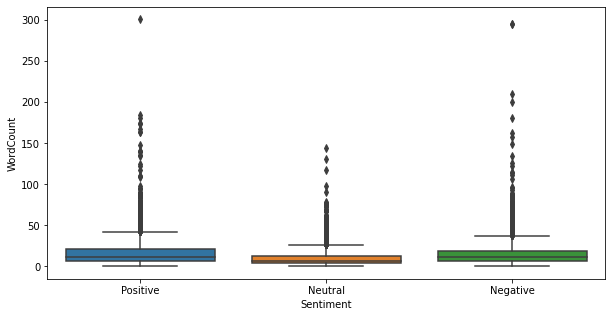

In [11]:
CommentLength = []
for i in range(0,urdu.shape[0]):
    CommentLength.append(len(urdu.post[i].split()))

wordCount = pd.DataFrame({'WordCount' : np.array(CommentLength), 'Sentiment':np.array(urdu.sentiment)})
sns.boxplot( x=wordCount["Sentiment"], y=wordCount["WordCount"] )

NOTE: We can see in the boxplot, that there are a few comments that appear to be outliers in terms of the number of words. It is not clearly apparent from this plot, if we have 0 word comments.  
Next, we check for zero word comments.

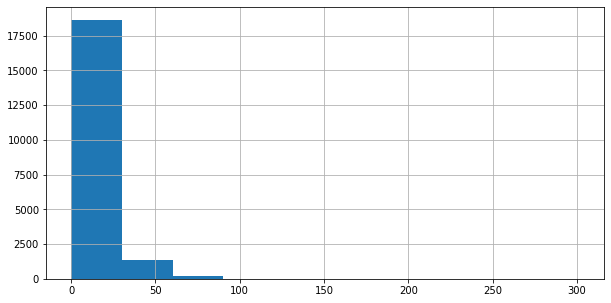

count    20228.000000
mean        13.284704
std         13.447479
min          0.000000
25%          5.000000
50%          9.000000
75%         17.000000
max        301.000000
dtype: float64

In [12]:
reviews_len = [len(x.split()) for x in urdu.post.to_list()]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

NOTE: There are 0 words in some cells, as we can see based on the minimum word count above. This might count whatever placeholder is in a cell, even if it doesn't contain text. I count the number of words to be sure 

In [13]:
# Show the sentiment for a selection of those with 0 words
print('Number of 0 word comments: ', wordCount[wordCount["WordCount"] == 0].shape[0])
print(wordCount[wordCount["WordCount"] == 0].value_counts())
wordCount.sort_values('WordCount').head()

Number of 0 word comments:  112
WordCount  Sentiment
0          Neutral      112
dtype: int64


,WordCount,Sentiment
8113,0,Neutral
8244,0,Neutral
8239,0,Neutral
7946,0,Neutral
7949,0,Neutral


In [14]:
# Also check the actual data, what is in the post column?
urdu.loc[[8113,8244,8239],:]

,post,sentiment
8113,,Neutral
8244,,Neutral
8239,,Neutral


NOTE: To remove, I just take the index of the count matrix, which is the same as for the urdu data set, and the use `drop` to remove the comments

In [15]:
index = []
for row in wordCount[wordCount["WordCount"] == 0].index: 
    index.append(row)

In [16]:
urdu = urdu.drop(index)
urdu.shape

(20116, 2)

NOTE: Next I inspect the comments that are outliers in the number of words (having a very large number of words), as per boxplot.

In [17]:
print(wordCount[wordCount["WordCount"] > 250].value_counts())
wordCount[wordCount["WordCount"] > 250]

WordCount  Sentiment
295        Negative     2
301        Positive     1
dtype: int64


,WordCount,Sentiment
12651,295,Negative
12652,295,Negative
13184,301,Positive


In [18]:
urdu.loc[[12651,12652,13184],:]

,post,sentiment
12651,Assalam o alaikum! Dosto kal hum ny Federal or...,Negative
12652,Assalam o alaikum! Dosto kal hum ny Federal or...,Negative
13184,Assalam o Alaikum! Main Ye 3 Cell Purchase kr ...,Positive


In [19]:
# Inspect one of them in full
urdu.post[12651]

"Assalam o alaikum! Dosto kal hum ny Federal or wo provinces jin mein abhi Ministerial posts ki upgradation nahi hoi, mein upgradation k liye protest start krnay k baray mein app logon ki opinion mangi thi. Kal sham sy ly kr ab tak humein jo response mila ha us k mutabiq 99.7% logon ny protest start krny ka mashwara diya ha or sath mein iss protest mein shareek honay ki yaqeen dehani bhi karai ha. Dosto jesa k aap log jantay hein k jin provinces mein upgradation hoi ha us k peachay jaddo jehad ki aik lambi dastaan ha. Wo kehtay hein na k jab tak bacha roye na to Maan bhi doodh nahi deti iss liye kabhi bhi koi plate mein rakh kr app ko apna haq nahi dy ga apna haq lenay k liye himmat or jazzba darkar ha jis ka izhar KPK or Punjab k dosto ny kiya or kamyaabi hasil ki. Dosto humaray liye aap logoon ki raaye ki bohat importance ha iss liye hum aaj sy apna protest start krny ka elaan krty hein. Iss silsaly mein pehla protest 14th January 2016 at 11:00 AM APCA (Pakistan Railway's Wing) k zae

NOTE: There are three columns that contain more than 250 words in the post. As we can see, two of them are also duplicates. We will deal with the duplicates later and for now, only remove them, as they are only three.

In [20]:
index = []
for row in wordCount[wordCount["WordCount"] > 250].index: 
    index.append(row)
    
urdu = urdu.drop(index)
urdu.reset_index(inplace=True)
urdu.shape

(20113, 3)

Check the boxplots again as a sanity check

<AxesSubplot:xlabel='Sentiment', ylabel='WordCount'>

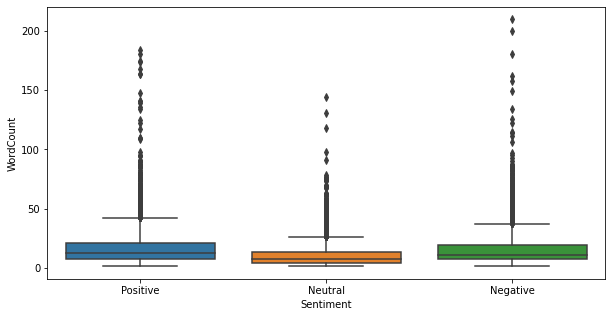

In [21]:
CommentLength = []
for i in range(0,urdu.shape[0]):
    CommentLength.append(len(urdu.post[i].split()))

wordCount = pd.DataFrame({'WordCount' : np.array(CommentLength), 'Sentiment':np.array(urdu.sentiment)})
sns.boxplot( x=wordCount["Sentiment"], y=wordCount["WordCount"] )

NOTE: I successfully removed the outliers. Now I am going to remove duplicates and check the distribution of number of words in the comments again.

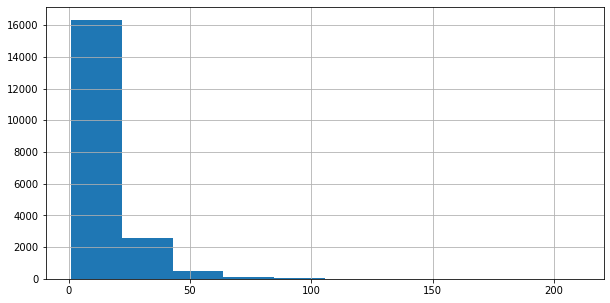

count    19624.000000
mean        13.479668
std         12.968949
min          1.000000
25%          6.000000
50%         10.000000
75%         17.000000
max        210.000000
dtype: float64

In [22]:
urdu.drop_duplicates(subset='post',inplace=True)

reviews_len = []
reviews_len = [len(x.split()) for x in urdu.post.to_list()]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

NOTE: The minimum is now 1 word. That is also worth inspecting.

In [23]:
print(wordCount[wordCount["WordCount"] ==1 ].value_counts())
wordCount[wordCount["WordCount"] == 1 ]

WordCount  Sentiment
1          Neutral      614
           Positive     104
           Negative      31
dtype: int64


,WordCount,Sentiment
32,1,Positive
33,1,Positive
339,1,Positive
350,1,Positive
367,1,Positive
...,...,...
14409,1,Positive
16615,1,Neutral
17001,1,Positive
17692,1,Negative


NOTE: There are quite a lot of comments with only one word. Let's look at some of them.

In [24]:
urdu.loc[[32, 33, 339, 350, 367, 14409, 16615, 17001,17692, 17694],:]

,index,post,sentiment
32,32,MashaAllah.,Positive
33,33,Mubarak,Positive
339,339,😁😁👍,Positive
350,350,Lol,Positive
367,367,Hahaha😂,Positive
14409,14524,W.aalikum.aslam.aap.ko.be.hum.pakistanyo.ke.ta...,Positive
16615,16730,Miss.shah.good.morning.kuch.khaa.k.aaya.krain....,Neutral
17001,17116,Jeo.hazrou.sal.minas.bahi,Positive
17692,17807,Begharti,Negative
17694,17809,Begairati,Negative


NOTE: Those are smileys or actually just one word. But there are cases, such as in the rows 14409, 16615 and 17001, where it appears that the comments are sentences, but contain dots instead of space between the words.

This shows that there are at least three sentences, that are counted as one word, although they are a sentence. 
So to retain at least those, I decided to just replace the dots with space. Unnecessary space will be removed further down anyways. ( The tokenisation code can be found in `urdu_sentiment/tokenise.py`)

I will do this in the tokenisation step further down, which will be the easiest way.

# 2. Preprocessing the comments with common NLP techniques
In the tokenisation step, I do the following:  

1. Remove numbers  
2. Remove punctuations
3. Remove Stop words and common names

This is wrapped in a if else statement, as I described above, some tokens are actually sentences, where the words are seperated by dots. In the if else statemetn, I first split the comments and replace the dots with a space, only for those comments, where the number of words is 1.


Now I check if the `createToken` function works on on comment

In [25]:
createToken(urdu['post'][32], stopWords, urduNames)

['mashaallah']

NOTE: Tokenise the whole list of comments and check if, after tokenisation, any comments are of 0 word length (probably the emoji only comments)

In [26]:
# Make a list of lists out of the post column in the data frame, then apply the above function to the whole list of comments
posts = urdu.post.tolist()
allTokenised = []
for post in posts:
  allTokenised.append(createToken(post, stopWords, urduNames))

allTokenised[0:5]

[['sai',
  'kha',
  'her',
  'kisi',
  'kay',
  'bus',
  'bat',
  'nhi',
  'lakin',
  'hal',
  'kal',
  'bi',
  'aj',
  'aj',
  'bi',
  'sirf',
  'aus',
  'say',
  'bus'],
 ['sahi', 'bt'],
 ['bt'],
 ['wah', 'je', 'wah'],
 ['are', 'wha', 'kaya', 'bat']]

In [27]:
tokenised_corp = tokeniseAll(posts, stopWords, urduNames)

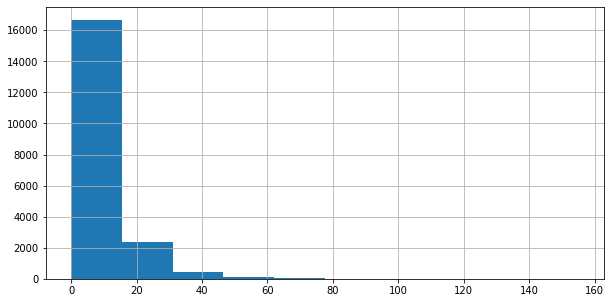

count    19624.000000
mean         9.291429
std          9.004221
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        155.000000
dtype: float64

In [28]:
reviews_len = [len(x) for x in tokenised_corp]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

NOTE: Indeed, there is a number of 0 length posts that occur after tokenisation. We will first encode our data and then remove the 0 length tokens

In [29]:
y = urdu.sentiment.values
X = np.array([' '.join(doc) for doc in tokenised_corp])
dic = {'Negative':'-1', 'Positive':'1', 'Neutral':'0'}
y = np.array([dic.get(n, n) for n in y])
print('Negatives: ', np.count_nonzero(y == '-1'))
print('Neutrals: ', np.count_nonzero(y == '0'))
print('Positives: ', np.count_nonzero(y == '1'))

Negatives:  5239
Neutrals:  8532
Positives:  5853


### Remove the tokens that are empty

In [30]:
X = np.array([ X[i] for i, l in enumerate(reviews_len) if l > 0 ])
y = np.array([ y[i] for i, l in enumerate(reviews_len) if l > 0 ])

# Training models

In order for the ML models to handle the data, we need to vectorise it. This means transforming the tokens into a sparse matrix.

Some info on sparse matrices [can be found here](https://towardsdatascience.com/working-with-sparse-data-sets-in-pandas-and-sklearn-d26c1cfbe067). 
>A sparse matrix is a matrix in which most of the elements are zero. On the contrary, a table in which the majority of elements are non zero is called dense. We define the sparsity of a matrix as the number of zero elements divided by the total number of elements. A matrix with sparsity greater than 0.5 is a sparse matrix.

In [31]:
# A quick check which words are 'rare'
cv = CountVectorizer()
X_count = cv.fit_transform(X)
sorted(cv.vocabulary_)[1:10]

['aa_gaey',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaappppp',
 'aaaallaaaa',
 'aaaallllaaaa',
 'aaah',
 'aaaiin']

### Set up the models and the stratified cross validator.

Some info: 

**TF-IDF**, short for 'Term Frequency - Inverse Document Frequency, creates a matrix, called corpus, of the total number of tokens (words) in the text, by the number of comments (tokens $\times$ \$n_{comments}\$ ), where the cells are the token frequency in the document (number of occurences), expressed as a probability, weighted by the number of occurences of that token/word in the comment, as compared to the whole number of comments.
Simpler: The TF-IDF weights comment specific but overall rare words higher.  
As per [scikit library](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer):  
>The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.


In [32]:
# Set up the TFIDF tokenisation
ftfIDF = TfidfVectorizer(max_df = 0.70, 
                         binary = False, 
                         sublinear_tf = True, 
                         use_idf = True)

# Stratified k-fold cross validation
stratifiedK = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)

# Multinomial Logistic Regression
mlRegression = LogisticRegression(random_state = 0, solver = 'liblinear', multi_class = 'auto')

# Multinomial Naive Bayes
mnBayes = MultinomialNB(alpha=0.25)

## Multinomial Logistic Regression
As the classes are not imbalanced, I am looking at accuracy at this stage.

In [33]:
scores = []
for train_index, test_index in stratifiedK.split(X, y):
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    #Vectorize the training values
    tf_idf = ftfIDF.fit_transform(X_train)
    
    #Fit the classifier to training data
    mlRegression = mlRegression.fit(tf_idf,y_train) 

    #Vectorize the test values
    X_test_tfidf = ftfIDF.transform(X_test) 
    
    #Predict on test values
    y_pred = mlRegression.predict(X_test_tfidf)
    y_pred_proba = mlRegression.predict_proba(X_test_tfidf)
    
    #Print out scores for this fold
    score = mlRegression.score(X_test_tfidf,y_test)
    print('Score: {:2.4f}'.format(score))
    scores.append(score)
    
#Print average score
print('Average Accuracy: {:2.4f}'.format(np.mean(scores)))

Score: 0.6288
Score: 0.6559
Score: 0.6431
Score: 0.6354
Score: 0.6400
Score: 0.6096
Score: 0.6281
Score: 0.6163
Score: 0.6311
Score: 0.6460
Average Accuracy: 0.6334


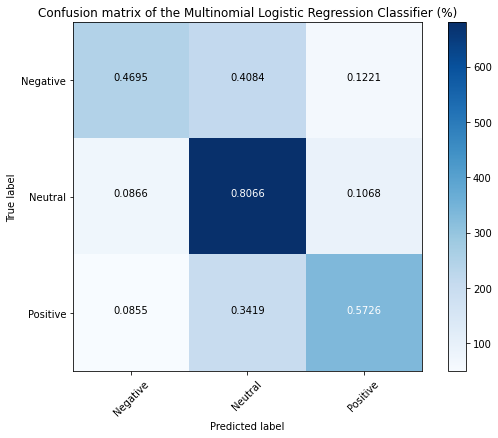


              precision    recall  f1-score   support

          -1      0.667     0.469     0.551       524
           0      0.622     0.807     0.702       843
           1      0.685     0.573     0.624       585

    accuracy                          0.646      1952
   macro avg      0.658     0.616     0.626      1952
weighted avg      0.653     0.646     0.638      1952



In [34]:
customPlt.plotConfMatrix(y_pred,y_test,
              target_names= ['Negative', 'Neutral', 'Positive'],
              title = 'Confusion matrix of the Multinomial Logistic Regression Classifier (%)',
              normalize = True)

print('')
print('======================================================')
print(classification_report(y_test, y_pred, digits=3))
print('======================================================')

## Training Multinomial Naive Bayes

In [35]:
scores = []
for train_index, test_index in stratifiedK.split(X, y):
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    #Vectorize the training values
    tf_idf = ftfIDF.fit_transform(X_train)
    
    #Fit the classifier to training data
    mnBayes = mnBayes.fit(tf_idf,y_train) 

    #Vectorize the test values
    X_test_tfidf = ftfIDF.transform(X_test) 
    
    #Predict on test values
    y_pred = mnBayes.predict(X_test_tfidf)
    y_pred_proba = mnBayes.predict_proba(X_test_tfidf)
    
    #Print out scores for this fold
    score = mnBayes.score(X_test_tfidf,y_test)
    print('Score: {:2.4f}'.format(score))
    scores.append(score)
    
#Print average score
print('Average Accuracy: {:2.4f}'.format(np.mean(scores)))

Score: 0.6272
Score: 0.6406
Score: 0.6380
Score: 0.6416
Score: 0.6313
Score: 0.6393
Score: 0.6265
Score: 0.6255
Score: 0.6291
Score: 0.6281
Average Accuracy: 0.6327


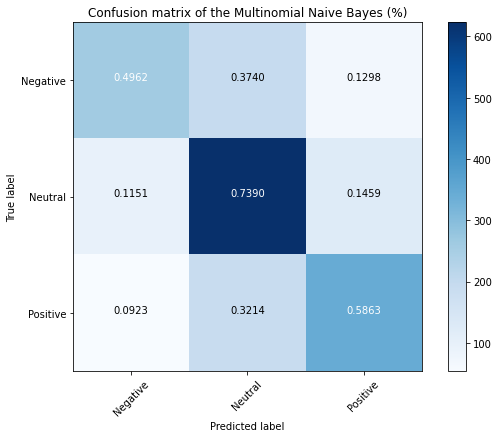


              precision    recall  f1-score   support

          -1      0.633     0.496     0.556       524
           0      0.619     0.739     0.674       843
           1      0.642     0.586     0.613       585

    accuracy                          0.628      1952
   macro avg      0.631     0.607     0.614      1952
weighted avg      0.629     0.628     0.624      1952



In [36]:
customPlt.plotConfMatrix(y_pred,y_test,
              target_names= ['Negative', 'Neutral', 'Positive'],
              title = 'Confusion matrix of the Multinomial Naive Bayes (%)',
              normalize = True)

print('')
print('======================================================')
print(classification_report(y_test, y_pred, digits=3))
print('======================================================')

## Conclusion on both models
For these two models, without grid search for parameter tunning, we can see that the Naive Bayes performs slightly better at teh task of predicting negative sentiments than the  Multinomial Logistic Regression. 
MNB is able to achieve a recall of 0.496 for the negative class, whereas the MLR is slightly under that with 0.469.
Overall the performance is very similar though.  
The overall accuracy is better in MLR, with 0.646 against 0.628 in MNB.

The results are far from striking.

## Optional fine tuning
for a production model, I would definitely perform parameter fine tuning. Below is the code to do so for Multinomial Bayes.

In [37]:
# Setting up a grid search pipeline for tfidf and NB
tvc_pipe = Pipeline([
 ('tfidf', TfidfVectorizer()),
 ('mb', MultinomialNB())
])

# Parameters for the search
tf_params = {
 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tfidf__use_idf': (True, False),
 'mb__alpha':[0.1, 0.15, 0.2, 0.25, 0.3,0.4, 0.5]
}

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = GridSearchCV(tvc_pipe, tf_params, cv=10, scoring = 'accuracy', n_jobs = -1)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))

              precision    recall  f1-score   support

          -1     0.6388    0.4629    0.5368      1039
           0     0.6246    0.7422    0.6783      1722
           1     0.6365    0.6154    0.6258      1144

    accuracy                         0.6307      3905
   macro avg     0.6333    0.6068    0.6137      3905
weighted avg     0.6319    0.6307    0.6253      3905



# Combining Positive and Neutral Sentiments
As my task is to predict negative sentiment, I descided to combine positive and neutral classes, to make it a binary classification. Not negative versus negative sentiment.

In [39]:
# Recode the neutral classes to 0; this is the same as the positive class now
y = urdu['sentiment'].copy().values
np.place(y,y == 'Negative',1)
np.place(y,y == 'Positive',0)
np.place(y,y == 'Neutral',0)
y = y.astype(int)

Again, we need to remove the 0 length comments, as below

In [40]:
y = np.array([ y[i] for i, l in enumerate(reviews_len) if l > 0 ])
np.bincount(y)

array([14286,  5239])

Check that X and y have the same number of entries and we did not make any mistakes

In [41]:
print(X.shape)
print(y.shape)

(19525,)
(19525,)


Count the number of comments per sentiment

In [42]:
unique, counts = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[    0, 14286],
       [    1,  5239]])

NOTE: We have now created an imbalanced training problem, hence I decided to also use the Synthetic Minority Oversampling Technique (SMOTE) to deal with this.

In [43]:
ftfIDF2 = TfidfVectorizer(max_df=0.75,
                             lowercase=False,
                             norm = 'l2',
                             sublinear_tf=True,
                             use_idf=False)

sm = SMOTE(sampling_strategy=1.0,
           random_state=5,
           k_neighbors=3)


## Multinomial Logistic Regression

In [44]:
for train_index, test_index in stratifiedK.split(X, y):
    X_train, y_train, X_test, y_test_mlr = X[train_index], y[train_index], X[test_index], y[test_index]
    
    #Vectorize the training values
    tf_idf = ftfIDF2.fit_transform(X_train)
        
    #Scale data if needed for kNN 
    scaler = MaxAbsScaler()
    tf_idf = scaler.fit_transform(tf_idf)
    
    # Apply smote
    tf_idf_sm, y_train_sm = sm.fit_resample(tf_idf, y_train)
    
    #Fit the classifier to training data
    mlRegression = mlRegression.fit(tf_idf_sm,y_train_sm) 

    #Vectorize the test values
    X_test_tfidf = ftfIDF2.transform(X_test) 
    
    #Predict on test values
    y_pred_mlr = mlRegression.predict(X_test_tfidf)
    y_pred_proba_mlr = mlRegression.predict_proba(X_test_tfidf)
    
    #Print out scores for this fold
    #score = mlRegression.score(X_test_tfidf,y_test)
    kappaScore = cohen_kappa_score(y_pred_mlr,y_test_mlr)
    print('Cohen`s kappa score: {:2.4f}'.format(kappaScore))
    scores.append(kappaScore)
    
#Print average score
print('Average Cohen`s Kappa: {:2.4f}'.format(np.mean(kappaScore)))

Cohen`s kappa score: 0.3358
Cohen`s kappa score: 0.3406
Cohen`s kappa score: 0.3760
Cohen`s kappa score: 0.3319
Cohen`s kappa score: 0.3829
Cohen`s kappa score: 0.3419
Cohen`s kappa score: 0.3006
Cohen`s kappa score: 0.3502
Cohen`s kappa score: 0.3762
Cohen`s kappa score: 0.3993
Average Cohen`s Kappa: 0.3993


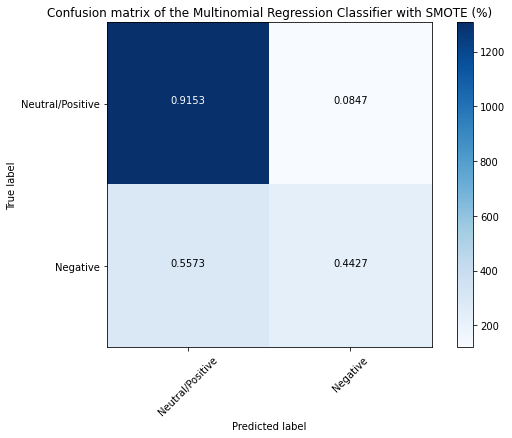


              precision    recall  f1-score   support

           0      0.817     0.915     0.864      1428
           1      0.657     0.443     0.529       524

    accuracy                          0.788      1952
   macro avg      0.737     0.679     0.696      1952
weighted avg      0.774     0.788     0.774      1952



In [45]:
customPlt.plotConfMatrix(y_pred_mlr,y_test_mlr,
              target_names= ['Neutral/Positive', 'Negative'],
              title = 'Confusion matrix of the Multinomial Regression Classifier with SMOTE (%)',
              normalize = True)

print('')
print('======================================================')
print(classification_report(y_test_mlr, y_pred_mlr, digits=3))
print('======================================================')

## Multinomial Naive Bayes

In [46]:
for train_index, test_index in stratifiedK.split(X, y):
    X_train, y_train, X_test, y_test_mnb = X[train_index], y[train_index], X[test_index], y[test_index]
    
    #Vectorize the training values
    tf_idf = ftfIDF2.fit_transform(X_train)
    
    #Scale data if needed for kNN 
    scaler = MaxAbsScaler()
    tf_idf = scaler.fit_transform(tf_idf)
    
    # Apply smote
    tf_idf_sm, y_train_sm = sm.fit_resample(tf_idf, y_train)
    
    #Fit the classifier to training data
    mnBayes = mnBayes.fit(tf_idf_sm,y_train_sm) 

    #Vectorize the test values
    X_test_tfidf = ftfIDF2.transform(X_test) 
    
    #Predict on test values
    y_pred_mnb = mnBayes.predict(X_test_tfidf)
    y_pred_proba_mnb = mnBayes.predict_proba(X_test_tfidf)
    
    #Print out scores for this fold
    #score = mnBayes.score(X_test_tfidf,y_test)
    kappaScore = cohen_kappa_score(y_pred_mnb,y_test_mnb)
    print('Cohen`s kappa score: {:2.4f}'.format(kappaScore))
    scores.append(kappaScore)
    
#Print average score
print('Average Cohen`s Kappa: {:2.4f}'.format(np.mean(kappaScore)))

Cohen`s kappa score: 0.3781
Cohen`s kappa score: 0.3398
Cohen`s kappa score: 0.4119
Cohen`s kappa score: 0.3673
Cohen`s kappa score: 0.4009
Cohen`s kappa score: 0.3568
Cohen`s kappa score: 0.3707
Cohen`s kappa score: 0.3690
Cohen`s kappa score: 0.3798
Cohen`s kappa score: 0.4040
Average Cohen`s Kappa: 0.4040


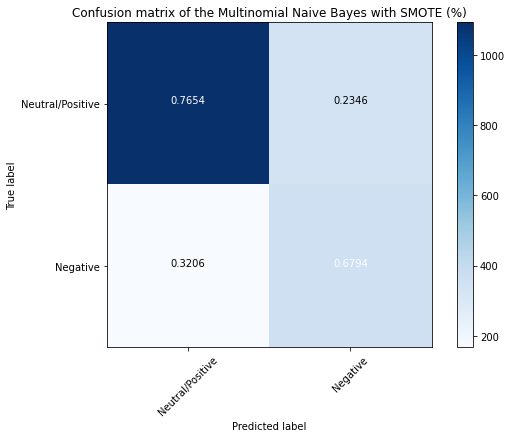


              precision    recall  f1-score   support

           0      0.867     0.765     0.813      1428
           1      0.515     0.679     0.586       524

    accuracy                          0.742      1952
   macro avg      0.691     0.722     0.699      1952
weighted avg      0.772     0.742     0.752      1952



In [47]:
customPlt.plotConfMatrix(y_pred_mnb,y_test_mnb,
              target_names= ['Neutral/Positive', 'Negative'],
              title = 'Confusion matrix of the Multinomial Naive Bayes with SMOTE (%)',
              normalize = True)

print('')
print('======================================================')
print(classification_report(y_test_mnb, y_pred_mnb, digits=3))
print('======================================================')

## Inspect the AUC-ROC and PRC-ROC

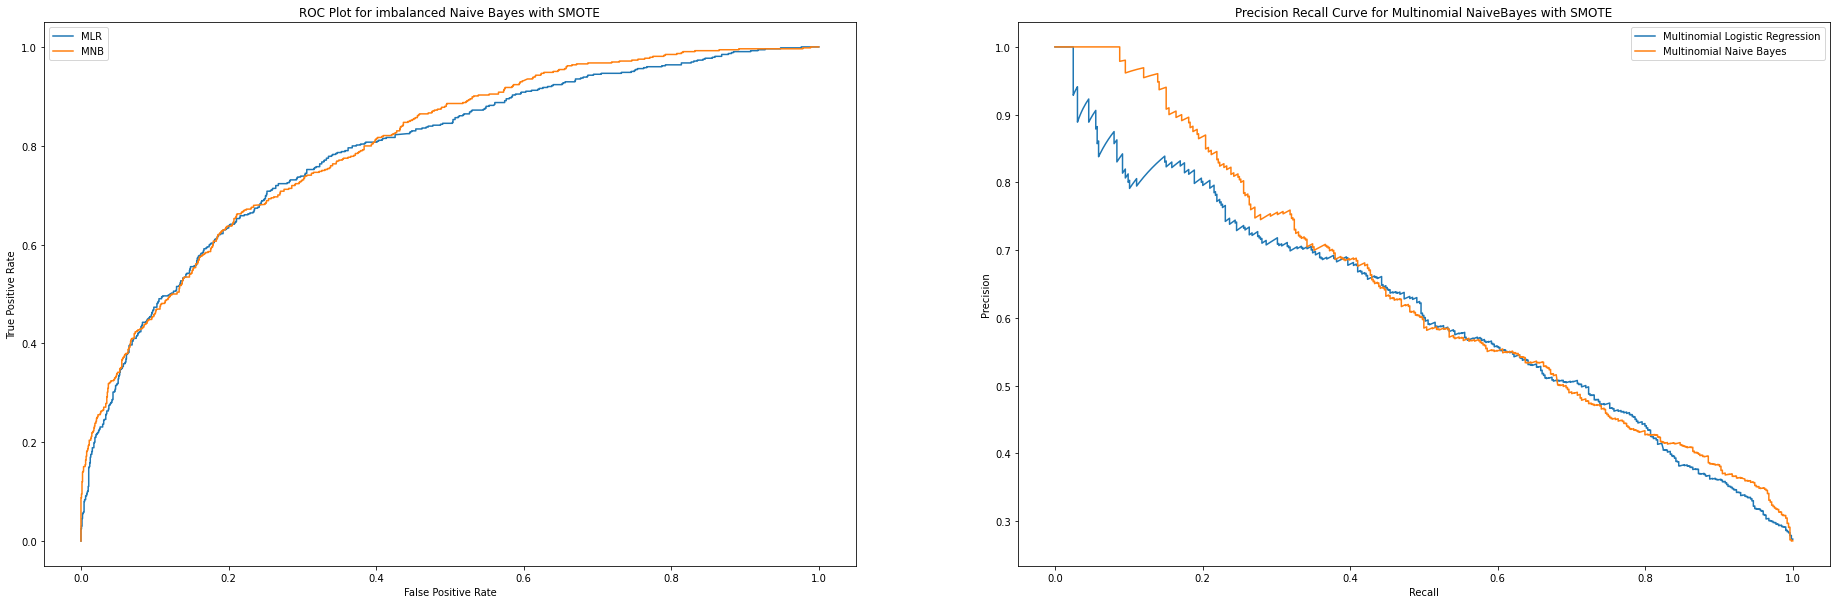

In [48]:
customPlt.plotCurves(y_test_mlr, 
               y_test_mnb, 
               y_pred_proba_mlr, 
               y_pred_proba_mnb)

# Conclusion
The binary classification performs drastically better than the multiclass prediction models.

Overall, I was able to improve the classification of negative sentiments in the following way

- Binary $\to$ Multiclass  

  - Multinomial Logistic Regression
      - Negative class specific Recall : 0.469 $\to$ 0.443
  - Multinomial Naive Bayes
      - Negative class specific Recall: 0.496 $\to$ 0.679

The ROC and PRC curves both show that the  Naive Bayes outperforms the Logistic Regression.
Hence, the best model is the __binary classifier Naive Bayes__

# Closing Remarks and Outlook

There are many other ways of performing this analysis, and many likely better models. One method I have identified is deep learning based and implements a [Long Short Term Memory (LSTM) deep learning model](https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948).
Further, one can leverage the pre-trained [RoBERTa model](https://towardsdatascience.com/discover-the-sentiment-of-reddit-subgroup-using-roberta-model-10ab9a8271b8) to perform the task. Both are very likely to perform better on the sentiment analysis.  

With this project, however, I just wanted to polish up my python skills and to get some understanding on NLP and sentiment analysis more so than training the perfect classifier in a field that was new to me. Hence, I put emphasis on how to set up a data science project folder and how to make it minimally reproducible with the inclusion of a `requirements.txt`. 

Further, I created a local minimal python package with some basic functions that I used in the notebook. I could have included those in the notebook, as this is a small test project, but in a real world data science project with multiple collaborators, it would be handy to have the long code chunks placed separately.